## Import Packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import torch.nn.functional as F
from scipy.stats import zscore
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler


## Create the model 

In [2]:
class NN(nn.Module):
    def __init__(self, input_size, num_output):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, num_output)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x


#  Data processing

In [5]:
df = pd.read_csv('data/updated_nn_dataset.csv')
index = df['class-0-latency'].index[df['class-0-latency'].apply(np.isnan)]
df = df.drop(index)

# target = df[target_col]


FileNotFoundError: [Errno 2] No such file or directory: '../data/updated_nn_dataset.csv'

# Hyper parameters

In [9]:
train_x = df[0:1500][['ar-0', 'ar-1', 'ar-2', 'ar-3', 'pr-0', 'pr-1', 'pr-2', 'pr-3']]
test_x = df[1500:][['ar-0', 'ar-1', 'ar-2', 'ar-3', 'pr-0', 'pr-1', 'pr-2', 'pr-3']]

learning_rate = 0.1
num_epochs = 1000


loss_func = nn.MSELoss()

# Saving models

In [10]:

def save_model(model_dictionary, name):
    checkpoint_directory = 'torch_directory'
    file_path = os.path.join(checkpoint_directory, name)
    torch.save(model_dictionary, file_path)

# Training method

In [12]:
def train_model(model, target_col, polyregress,name):
    #getting y values for training and test set
    train_y = df[0:1500][[target_col]].to_numpy()
    test_y = df[1500:][[target_col]].to_numpy()
    
    #initialzie the otpimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_loss = []
    
    #train on training data
    for epoch in range(num_epochs):
        train_features = torch.from_numpy(train_x.to_numpy()).float() / 100
        if polyregress:
            train_polyFeatures = torch.cat(
                (train_features, train_features * train_features, train_features * train_features * train_features),
                dim=1)
        else:
            train_polyFeatures = train_features
        prediction = model(train_polyFeatures)

        loss = loss_func(prediction.float(), torch.from_numpy(train_y).float())
        optimizer.zero_grad()  # clear gradients for next train
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients
        train_loss.append(loss.data.numpy())
        
    # normalize the test features
    test_features = torch.from_numpy(test_x.to_numpy()).float() / 100
    if polyregress:
        test_polyFeatures = torch.cat(
            (test_features, test_features * test_features, test_features * test_features * test_features), dim=1)
    else:
        test_polyFeatures = test_features
        plt.ylim(0, 2)
    #get predictions for test samples
    predict_test_y = model(test_polyFeatures)
    
    #save model
    save_model(model,name)
    
    # dataframe to store test values and predictions
    df_test = pd.DataFrame({'p-' + target_col: predict_test_y.detach().numpy().tolist(), target_col: test_y.tolist()})

    df_test = df_test.sort_values(by=[target_col])

    cl_1_bw_list = df_test[target_col].tolist()

    cl_1_pbw_list = df_test['p-' + target_col].tolist()
    x = np.arange(0, len(cl_1_pbw_list))
    
    #plotting the original values and predictions
    plt.scatter(x=x, y=cl_1_bw_list, c='blue', label='test original')
    plt.scatter(x=x, y=cl_1_pbw_list, c='orange', label='test predicted')
    plt.title('prediction using torch for ' + target_col)
    plt.legend()
    plt.show()
    return model

#  Calling the train function

torch.Size([327, 24])
len_cl_1_pbw_list  327


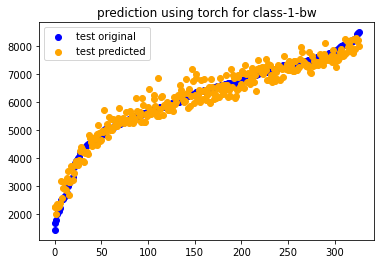

torch.Size([327, 24])
len_cl_1_pbw_list  327


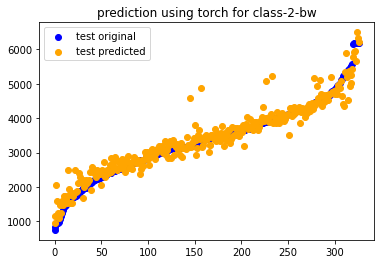

torch.Size([327, 8])
len_cl_1_pbw_list  327


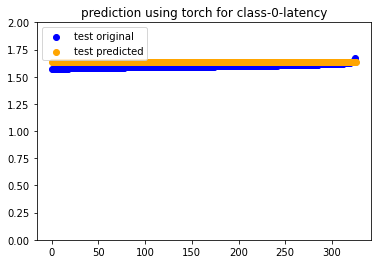

NN(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=1, bias=True)
)

In [14]:
if not os.path.exists('torch_directory'):
    os.makedirs('torch_directory')

model_bw_1 = NN(24, 1)

train_model(model_bw_1, 'class-1-bw', True,'model_bw_1.pt')

model_bw_2 = NN(24, 1)

train_model(model_bw_2, 'class-2-bw', True,'model_bw_2.pt')

model_nn = NN(8, 1)

train_model(model_nn, 'class-0-latency', False,'model_nn.pt')


# Function to load model

In [21]:
def load_model_parameters(name):
    checkpoint_directory = 'torch_directory'
    checkpoint_file = name
    full_path = os.path.join(checkpoint_directory, checkpoint_file)
    model_load = torch.load(full_path)
 
    return model_load


# Function to plot and save figures

In [22]:
def pl(ar,name,color):
    for j in ar:
        plt.title(name)
        plt.plot(j,color=color)
    # plt.ylim(0,150)
    plt.savefig('plots/'+name)
    plt.show()

# Initialize Variables

In [32]:
sample_num = 1
ar0 = []
ar1 = []
ar2 = []
ar3 = []
pr0 = []
pr1 = []
pr2 = []
pr3 = []
x1 = []
const = float(27200 * 27200)
mse = torch.nn.MSELoss()
    
num_steps = 100  

# Loading models

In [33]:
for x in range(0,50):
    
    #loading models
    model_bw_1 = load_model_parameters('model_bw_1.pt')
    model_bw_2 = load_model_parameters('model_bw_2.pt')
    model_nn = load_model_parameters('model_nn.pt')
    
    # switching off gradients
    model_bw_1.requires_grad_(requires_grad=False)
    model_bw_2.requires_grad_(requires_grad=False)
    model_nn.requires_grad_(requires_grad=False)
    
    # getting inputs
    ain = torch.from_numpy(
        df[x:x+sample_num][['ar-0', 'ar-1', 'ar-2', 'ar-3', 'pr-0', 'pr-1', 'pr-2', 'pr-3']].to_numpy()).float()
    ain = ain / 100
    ain1 = ain.clone()
    # creating polynomial features of degree 3 and switching on the gradients of inputs
    x = torch.cat((ain1, ain1 * ain1, ain1 * ain1 * ain1), dim=1)
    x.requires_grad = True    
    optima = optim.Adam([x], lr=0.01)
    param = [] # AR-PR values parameters
    
    # Loop for updating inputs for optimizing better outputs
    for i in range(num_steps):
        
        max_bw = torch.FloatTensor([27200] * sample_num)  
        max_bw = torch.reshape(max_bw, (sample_num, 1))

        min_lat = torch.FloatTensor([0] * sample_num)
        min_lat = torch.reshape(min_lat, (sample_num, 1))
        
        # getting the values form the model
        y1 = model_bw_1(x).float()
        y2 = model_bw_2(x).float()
        y3 = model_nn(x[:, :8]).float()
        p = 0
       
     
        #penalty and caping for AR0-AR3<1 and PR0-PR4>4
        l = x[:, 4:8][0].mul(100)>99
        if True in l:
            x
            p+= 500
        l = x[:, 0:4][0].mul(100) < 1

        if True in l:
            
            p+= -500
        
        
        #penalty for sum(PR0-PR4)>100
        l = torch.sum(x[:, 0:4][0].mul(100)) > 100

        if True in l:
            
            p += 200
       
        # aggregating the cumulative loss and updating the inputs
        loss = mse(y1, max_bw) / const + mse(y2, max_bw) / const + mse(y3, min_lat) / 3 + p        
        loss.backward()
        optima.step()
        optima.zero_grad()
        
        # storing the renormalized values for 
        param.append(list(x[:, :8].clone().detach().mul(100).numpy()[0]))
      
    #converting and adding the parameters to the list
    l_2d_t = np.array(param).T.tolist()

    ar0.append(l_2d_t[0])
    ar1.append(l_2d_t[1])
    ar2.append(l_2d_t[2])
    ar3.append(l_2d_t[3])
    pr0.append(l_2d_t[4])
    pr1.append(l_2d_t[5])
    pr2.append(l_2d_t[6])
    pr3.append(l_2d_t[7])


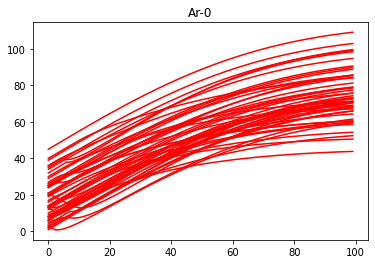

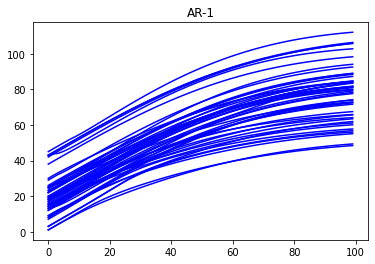

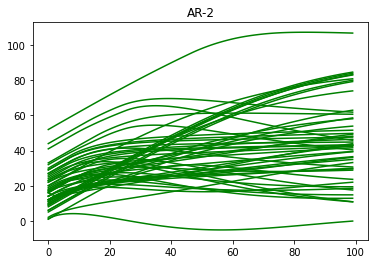

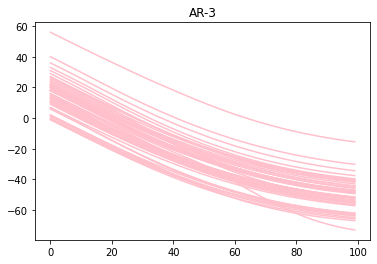

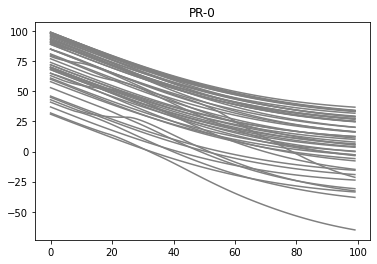

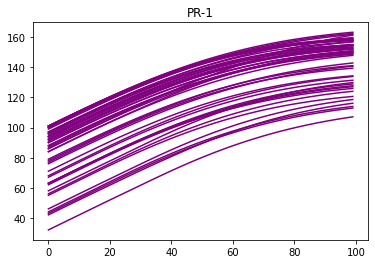

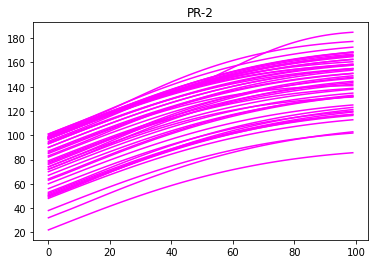

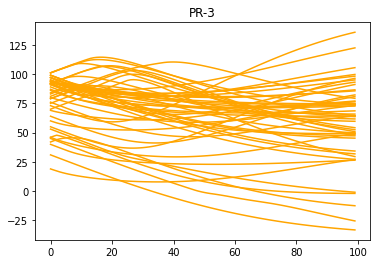

In [34]:
# Plotting the parameters
pl(ar0,'Ar-0','red')

pl(ar1,'AR-1','blue')
pl(ar2,'AR-2','green')
pl(ar3,'AR-3','pink')
pl(pr0,'PR-0','grey')
pl(pr1,'PR-1','purple')
pl(pr2,'PR-2','magenta')
pl(pr3,'PR-3','orange')
